In [2]:
import os
import glob
import requests
import time
from shutil import copyfile
import pandas as pd
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
import image_utils
from sklearn.externals import joblib
import cv2

%matplotlib inline

## Load images

In [3]:
# read data
filelist = glob.glob('../../data/fashion_models/dresses/*.jpg')
filelist = sorted(filelist)
print('num images: ', len(filelist))

num images:  63103


# Get Feature Vectors

In [4]:
def get_edges_for_img(img_path, img_size, crop=False):
    img = Image.open(img_path)
    if crop:
        w, h = img.size
        img = img.crop((70, 0, w-70, h))
    img = img.resize(img_size, Image.ANTIALIAS)
    img = img.filter(ImageFilter.FIND_EDGES)
    img = img.convert('L')
    img_arr = np.array(img)
    img.close()
    
    return(img_arr)

In [5]:
def get_outline_for_img(img_path, img_size, crop=False):
    outline = get_outline(img_path, crop)
    img = Image.fromarray(outline)
    img = img.resize(img_size)
    img_arr = np.array(img)
    img.close()
    
    return(img_arr)

In [6]:
def get_outline(img_path, crop=False, threshold=200):
    # Read image
    im_in = cv2.imread(img_path)
    if crop:
        im_in = im_in[0:256, 70:186]
    im_in = cv2.cvtColor(im_in, cv2.COLOR_BGR2GRAY)

    im_in = cv2.GaussianBlur(im_in, (5, 5), 0)
    ret, thresh = cv2.threshold(im_in, threshold, 255, cv2.THRESH_BINARY)
    newimg = cv2.bitwise_not(thresh)

    im2, contours, hierarchy = cv2.findContours(newimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cv2.drawContours(newimg, [cnt], 0, 255, -1)

#     edged = cv2.bitwise_not(cv2.Canny(newimg, 0, 255))
    
    smooth = cv2.GaussianBlur(newimg, (9, 9), 0)
    _, thresh2 = cv2.threshold(smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((2, 2), np.uint8)
    erosion2 = cv2.dilate(thresh2, kernel, iterations=1)

    return erosion2

In [7]:
def get_edges(file_list, img_size, smooth=False, cropped=False, print_progress=False):
    imgs = []
    
    get_edges_fun = get_outline_for_img if smooth else get_edges_for_img
    
    for idx, img_path in enumerate(file_list):
        if (idx % 5000 == 0) & print_progress:
            print(idx)
        
        imgs.append(get_edges_fun(img_path, img_size, crop=cropped))
        
    X = np.array([img for img in imgs])
    return(X)

In [8]:
img_size = [64, 64]

In [ ]:
outlines = get_edges(filelist, img_size, smooth=True, cropped=True, print_progress=True)
np.save('./clustering/features_outlines.npy', outlines)

In [9]:
edges = np.load('./clustering/features_edges.npy')
edges_crop = np.load('./clustering/features_edges_crop.npy')
outlines = np.load('./clustering/features_outlines.npy')

In [12]:
akiwi_114_files = glob.glob('../../data/features/fashion_models/dresses/114/*.npy')
akiwi_114 = []
for f in akiwi_114_files:
    akiwi_114.append(image_utils.load_feature_vector(f))

In [13]:
akiwi_114 = np.array(akiwi_114)

(62655, 114)

In [9]:
print(edges.shape)
print(edges_crop.shape)
print(outlines.shape)

(63103, 64, 64)
(63103, 64, 64)
(63103, 64, 64)


# Cluster
Find clusters - usually whole model image, zoomed model image and detail images

In [14]:
X = akiwi_114.reshape([akiwi_114.shape[0], np.prod(akiwi_114.shape[1:])])
X.shape

(62655, 114)

In [15]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
joblib.dump(kmeans, './clustering/kmeans_akiwi114_4.pkl') 

['./clustering/kmeans_akiwi114_4.pkl']

##  Visualize Clusters

In [16]:
def plot_images_by_cluster(df_cluster, num_imgs, plot_center=False, cluster_centers=None):
    n_clusters = df_cluster.cluster.nunique()        
    imgs = df_cluster.groupby('cluster').agg({'path': 'unique'})
    random.seed(42)
    
    ncols = num_imgs+1 if plot_center else num_imgs
    fig, axarr = plt.subplots(nrows=n_clusters, ncols=ncols, figsize=(2*num_imgs, 2*n_clusters))
    
    for cluster in imgs.index:
        cluster_imgs = imgs.loc[cluster, 'path'].tolist()
        print('Cluster {}: {} images'.format(cluster, len(cluster_imgs)))
        cluster_imgs = random.sample(cluster_imgs, num_imgs)
        
        plt_idx = 0
        if plot_center:
            ax = axarr[cluster][plt_idx]
            ax.axis('off')
            center = np.array(cluster_centers)[cluster]
            img = Image.fromarray(center.reshape(img_size))
            ax.imshow(img)
            plt_idx = 1
        
        for img_path in cluster_imgs:
            ax = axarr[cluster][plt_idx]
            ax.axis('off')
            img = Image.open(img_path)
            ax.imshow(img)
            plt_idx += 1
            
    plt.show()

In [17]:
def plot_cluster_centers(centers):
    
    fig=plt.figure(figsize=(4, 4))
    
    for idx, center in enumerate(centers):
        ax = fig.add_subplot(2, 2, idx+1)
        ax.axis('off')
        center = center.reshape(img_size)
        img = Image.fromarray(center)
        plt.imshow(img)
    plt.show()

In [18]:
def load_kmeans_model(path):
    kmeans = joblib.load(path)
    clusters = kmeans.labels_.tolist()
    centers = np.array(kmeans.cluster_centers_)
    
    return clusters, centers

In [19]:
kmeans2_clusters, kmeans2_centers = load_kmeans_model('./clustering/kmeans_edges_2.pkl')
kmeans3_clusters, kmeans3_centers = load_kmeans_model('./clustering/kmeans_edges_3.pkl')
kmeans4_clusters, kmeans4_centers = load_kmeans_model('./clustering/kmeans_edges_4.pkl')
outline_clusters, outline_centers = load_kmeans_model('./clustering/kmeans_outlines_4.pkl')
akiwi114_clusters, akiwi114_centers = load_kmeans_model('./clustering/kmeans_akiwi114_4.pkl')

# Amount of images by clusters

In [20]:
df2 = pd.DataFrame(list(zip(kmeans2_clusters, filelist)), columns=['cluster', 'path'])
df2.groupby('cluster').count()

,path
cluster,
0,10135
1,52968


In [21]:
df3 = pd.DataFrame(list(zip(kmeans3_clusters, filelist)), columns=['cluster', 'path'])
df3.groupby('cluster').count()

,path
cluster,
0,12960
1,41879
2,8264


In [22]:
df4 = pd.DataFrame(list(zip(kmeans4_clusters, filelist)), columns=['cluster', 'path'])
df4.groupby('cluster').count()

,path
cluster,
0,22933
1,22986
2,9427
3,7757


In [23]:
df4o = pd.DataFrame(list(zip(outline_clusters, filelist)), columns=['cluster', 'path'])
df4o.groupby('cluster').count()

,path
cluster,
0,19320
1,15484
2,10391
3,17908


In [24]:
df4ak = pd.DataFrame(list(zip(akiwi114_clusters, filelist)), columns=['cluster', 'path'])
df4ak.groupby('cluster').count()

,path
cluster,
0,18072
1,14893
2,16364
3,13326


## Cluster centers

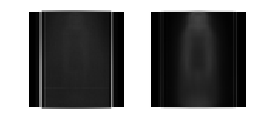

In [39]:
plot_cluster_centers(kmeans2_centers)

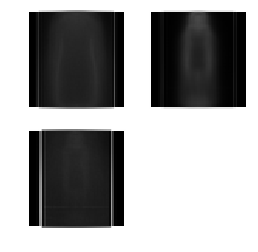

In [40]:
plot_cluster_centers(kmeans3_centers)

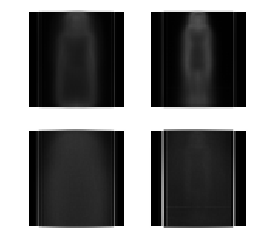

In [41]:
plot_cluster_centers(kmeans4_centers)

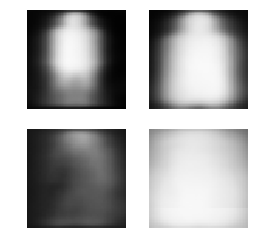

In [42]:
plot_cluster_centers(outline_centers)

## Plot random sample of images

Cluster 0: 10135 images
Cluster 1: 52968 images


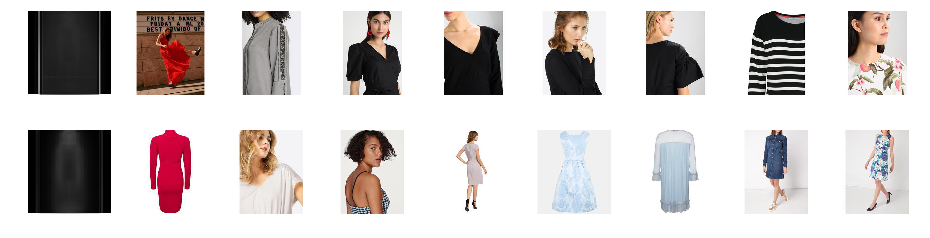

In [43]:
plot_images_by_cluster(df2, 8, plot_center=True, cluster_centers=kmeans2_centers)

Cluster 0: 12960 images
Cluster 1: 41879 images
Cluster 2: 8264 images


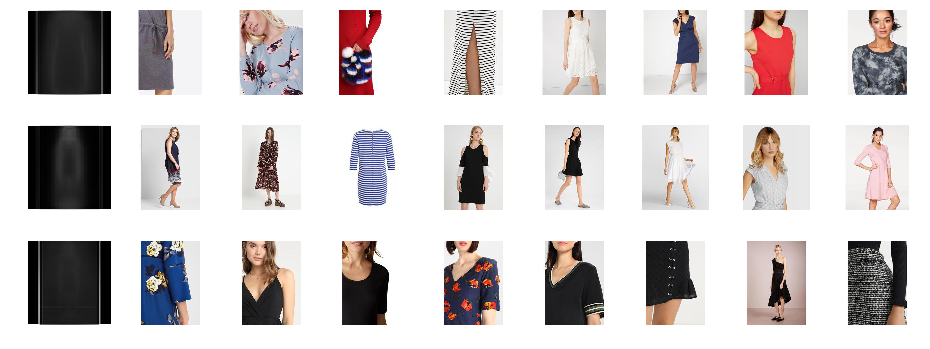

In [44]:
plot_images_by_cluster(df3, 8, plot_center=True, cluster_centers=kmeans3_centers)

Cluster 0: 22933 images
Cluster 1: 22986 images
Cluster 2: 9427 images
Cluster 3: 7757 images


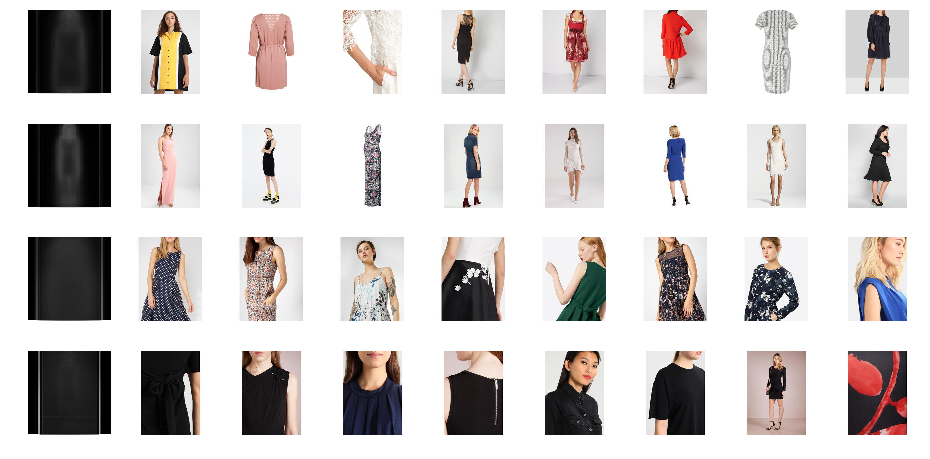

In [45]:
plot_images_by_cluster(df4, 8, plot_center=True, cluster_centers=kmeans4_centers)

Cluster 0: 19320 images
Cluster 1: 15484 images
Cluster 2: 10391 images
Cluster 3: 17908 images


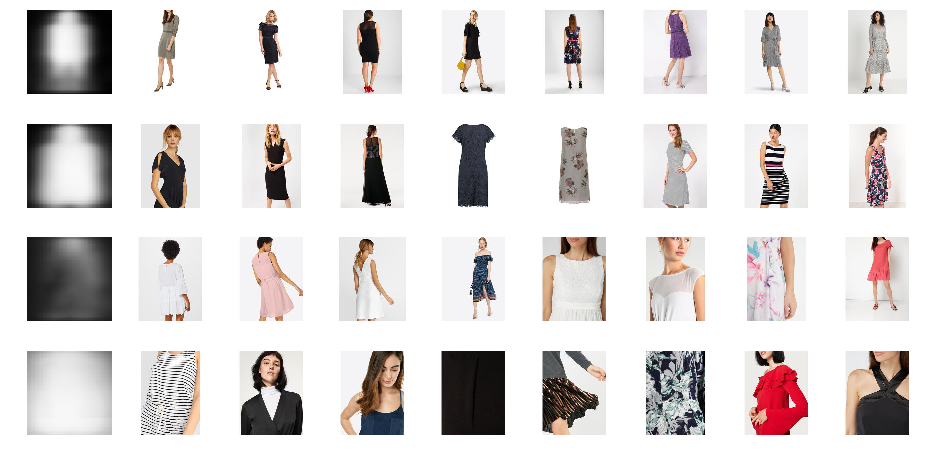

In [46]:
plot_images_by_cluster(df4o, 8, plot_center=True, cluster_centers=outline_centers)

Cluster 0: 18072 images
Cluster 1: 14893 images
Cluster 2: 16364 images
Cluster 3: 13326 images


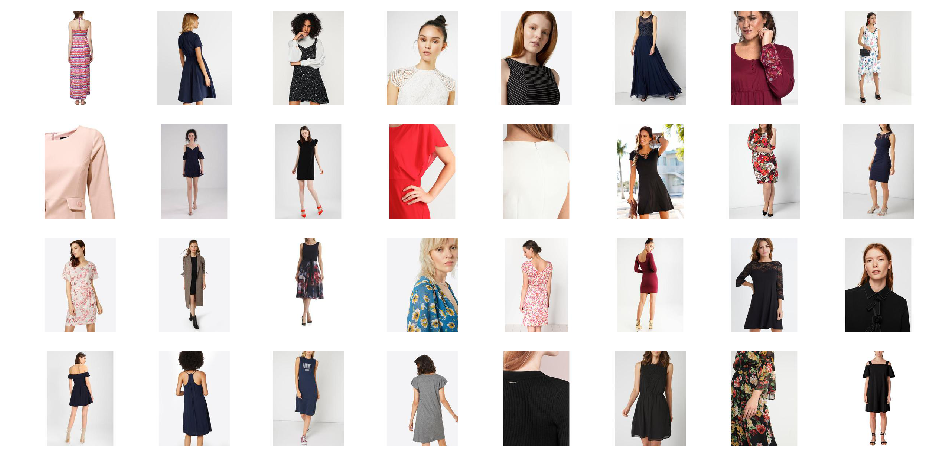

In [27]:
plot_images_by_cluster(df4ak, 8, plot_center=False, cluster_centers=akiwi114_centers)

## Select image for each product

In [28]:
def get_id_from_img_path(img_path):
    return os.path.basename(img_path).split('@')[0]

In [29]:
def plot_product_imgs(product_id, cluster_centers, smooth=False, crop=False):
    product_files = [f for f in filelist if get_id_from_img_path(f) == product_id]
    features = get_edges(product_files, img_size, smooth=smooth, cropped=crop)
    features = features.reshape(features.shape[0], np.prod(features.shape[1:]))
    
    dist = pairwise_distances(features, cluster_centers)
    img_clusters = dist.argmin(1)
    
    fig, axarr = plt.subplots(nrows=1, ncols=len(product_files), figsize=(len(product_files)*2, 2))
    
    for idx, product_file in enumerate(product_files):
        ax = axarr[idx]
        img = Image.open(product_file)
        ax.set_title(img_clusters[idx])
        ax.axis('off')
        ax.imshow(img)
    
    plt.show()

In [58]:
def plot_best_image_by_clusters(cluster_centers, product_id, features):
    n_centers = len(cluster_centers)
    
    fig, axarr = plt.subplots(nrows=1, ncols=n_centers,
                              figsize=(n_centers*2, 2))

    product_idxs = [idx for idx, f in enumerate(filelist) if get_id_from_img_path(f) == product_id]
    product_files = np.array(filelist)[product_idxs]
    product_feats = features[product_idxs]
    product_feats = product_feats.reshape(product_feats.shape[0], 
                                          np.prod(product_feats.shape[1:]))

    dist = pairwise_distances(product_feats, cluster_centers)
    imgs_idxs = dist.argmin(0)

    for idx, img_idx in enumerate(imgs_idxs):
        ax = axarr[idx]
        ax.axis('off')
        img = Image.open(product_files[img_idx])
        ax.imshow(img)
    
    plt.tight_layout()
    plt.show()

In [31]:
product_ids = list(set([get_id_from_img_path(f) for f in filelist]))

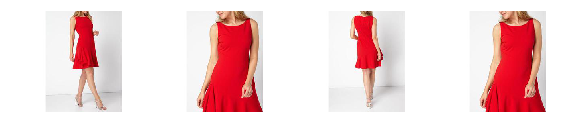

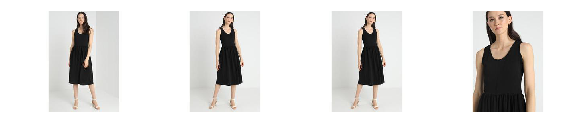

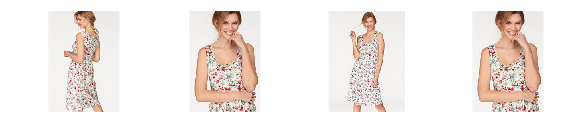

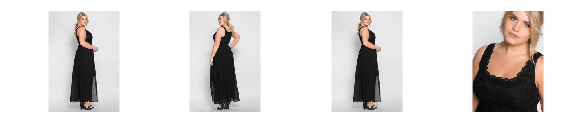

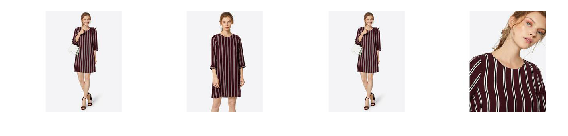

In [59]:
for product_id in product_ids[:5]:
    plot_best_image_by_clusters(outline_centers, product_id, outlines)

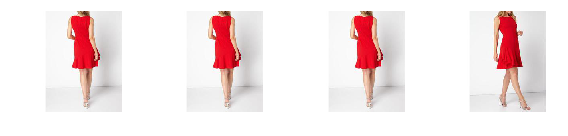

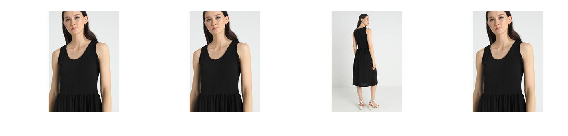

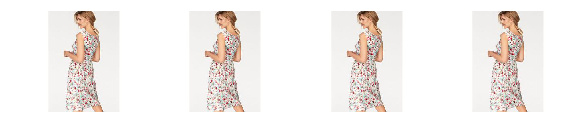

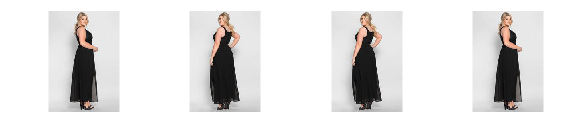

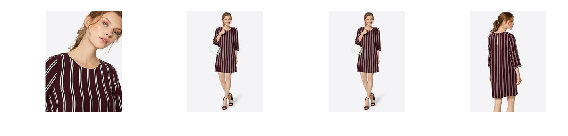

In [62]:
for product_id in product_ids[:5]:
    plot_best_image_by_clusters(akiwi114_centers, product_id, akiwi_114)

# Save Clustered Images

In [76]:
save_dir = '../../data/fashion_models/dresses_clustered/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [75]:
def get_best_image_for_cluster(img_features, cluster_center):
    
    img_features = img_features.reshape(img_features.shape[0], 
                                        np.prod(img_features.shape[1:]))
    dist = pairwise_distances(img_features, cluster_center.reshape(1, -1))
    best_img_idx = dist.argmin()
    
    return best_img_idx

In [78]:
best_cluster_center = outline_centers[0]

for idx, product_id in enumerate(product_ids):
    if idx % 100 == 0:
        print('Clustered: {} / {}'.format(idx, len(product_ids)))

    product_files = [f for f in filelist if get_id_from_img_path(f) == product_id]
    edges = get_edges(product_files, img_size, smooth=True, cropped=True)
    img_idx = get_best_image_for_cluster(edges, best_cluster_center)
    
    src_path = product_files[img_idx]
    dst_path = os.path.join(save_dir, product_id + '.jpg')
    
    if not os.path.exists(dst_path):
        copyfile(src_path, dst_path)

Clustered: 0 / 15304
Clustered: 100 / 15304
Clustered: 200 / 15304
Clustered: 300 / 15304
Clustered: 400 / 15304
Clustered: 500 / 15304
Clustered: 600 / 15304
Clustered: 700 / 15304
Clustered: 800 / 15304
Clustered: 900 / 15304
Clustered: 1000 / 15304
Clustered: 1100 / 15304
Clustered: 1200 / 15304
Clustered: 1300 / 15304
Clustered: 1400 / 15304
Clustered: 1500 / 15304
Clustered: 1600 / 15304
Clustered: 1700 / 15304
Clustered: 1800 / 15304
Clustered: 1900 / 15304
Clustered: 2000 / 15304
Clustered: 2100 / 15304
Clustered: 2200 / 15304
Clustered: 2300 / 15304
Clustered: 2400 / 15304
Clustered: 2500 / 15304
Clustered: 2600 / 15304
Clustered: 2700 / 15304
Clustered: 2800 / 15304
Clustered: 2900 / 15304
Clustered: 3000 / 15304
Clustered: 3100 / 15304
Clustered: 3200 / 15304
Clustered: 3300 / 15304
Clustered: 3400 / 15304
Clustered: 3500 / 15304
Clustered: 3600 / 15304
Clustered: 3700 / 15304
Clustered: 3800 / 15304
Clustered: 3900 / 15304
Clustered: 4000 / 15304
Clustered: 4100 / 15304
Clus